In [3]:
import numpy as np

In [4]:
def anisotropic_diffusion(img, niter=1, kappa=50, gamma=0.1, voxelspacing=None, option=1):
    r"""
    Edge-preserving, XD Anisotropic diffusion.


    Parameters
    ----------
    img : array_like
        Input image (will be cast to numpy.float).
    niter : integer
        Number of iterations.
    kappa : integer
        Conduction coefficient, e.g. 20-100. ``kappa`` controls conduction
        as a function of the gradient. If ``kappa`` is low small intensity
        gradients are able to block conduction and hence diffusion across
        steep edges. A large value reduces the influence of intensity gradients
        on conduction.
    gamma : float
        Controls the speed of diffusion. Pick a value :math:`<= .25` for stability.
    voxelspacing : tuple of floats or array_like
        The distance between adjacent pixels in all img.ndim directions
    option : {1, 2, 3}
        Whether to use the Perona Malik diffusion equation No. 1 or No. 2,
        or Tukey's biweight function.
        Equation 1 favours high contrast edges over low contrast ones, while
        equation 2 favours wide regions over smaller ones. See [1]_ for details.
        Equation 3 preserves sharper boundaries than previous formulations and
        improves the automatic stopping of the diffusion. See [2]_ for details.

    Returns
    -------
    anisotropic_diffusion : ndarray
        Diffused image.


    References
    ----------
    .. [1] P. Perona and J. Malik.
       Scale-space and edge detection using ansotropic diffusion.
       IEEE Transactions on Pattern Analysis and Machine Intelligence,
       12(7):629-639, July 1990.
    .. [2] M.J. Black, G. Sapiro, D. Marimont, D. Heeger
       Robust anisotropic diffusion.
       IEEE Transactions on Image Processing,
       7(3):421-432, March 1998.
    """
    # define conduction gradients functions
    if option == 1:
        def condgradient(delta, spacing):
            return np.exp(-(delta/kappa)**2.)/float(spacing)
    elif option == 2:
        def condgradient(delta, spacing):
            return 1./(1.+(delta/kappa)**2.)/float(spacing)
    elif option == 3:
        kappa_s = kappa * (2**0.5)

        def condgradient(delta, spacing):
            top = 0.5*((1.-(delta/kappa_s)**2.)**2.)/float(spacing)
            return np.where(np.abs(delta) <= kappa_s, top, 0)

    # initialize output array
    out = np.array(img, dtype=np.float32, copy=True)

    print("out type ",out.dtype)
    print("out shape ",out.shape)

    # set default voxel spacing if not supplied
    if voxelspacing is None:
        voxelspacing = tuple([1.] * img.ndim)

    # initialize some internal variables
    deltas = [np.zeros_like(out) for _ in range(out.ndim)]

    print("deltas start")
    print(deltas)

    for _ in range(niter):

        # calculate the diffs
        print("out ndim ", out.ndim)
        for i in range(out.ndim):
            slicer = [slice(None, -1) if j == i else slice(None) for j in range(out.ndim)]
            print(slicer)
            deltas[i][slicer] = np.diff(out, axis=i)

        print("deltas after slice = diffs")
        print(deltas)

        # update matrices
        matrices = [condgradient(delta, spacing) * delta for delta, spacing in zip(deltas, voxelspacing)]

        print("Matrices")
        print(matrices)

        # subtract a copy that has been shifted ('Up/North/West' in 3D case) by one
        # pixel. Don't as questions. just do it. trust me.
        for i in range(out.ndim):
            slicer = [slice(1, None) if j == i else slice(None) for j in range(out.ndim)]
            print(slicer)
            print("diff in axis ",i)
            print(np.diff(matrices[i], axis=i))
            matrices[i][slicer] = np.diff(matrices[i], axis=i)
            print("mat in axis ",i)
            print(matrices[i])

        print("Matrices after diff")
        print(matrices)

        # update the image
        out += gamma * (np.sum(matrices, axis=0))

    return out

float64
(233, 216)


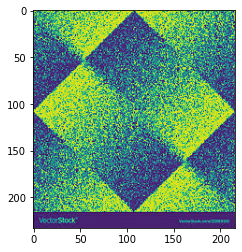

In [23]:
from matplotlib import image
from matplotlib import pyplot

ima = image.imread('noise_img.jpeg')

ima = ima/255

ima = np.mean(ima, axis=2)

print(ima.dtype)
print(ima.shape)

pyplot.imshow(ima)
pyplot.show()

out type  float32
out shape  (233, 216)
out ndim  2
[slice(None, -1, None), slice(None, None, None)]
[slice(None, None, None), slice(None, -1, None)]
float32
(233, 216)


/tmp/ipykernel_3989/4259659388.py:81: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = np.diff(out, axis=i)
/tmp/ipykernel_3989/4259659388.py:93: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = np.diff(matrices[i], axis=i)


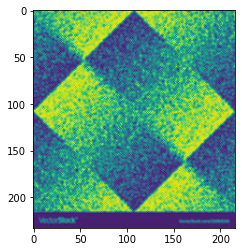

In [24]:
smooth = anisotropic_diffusion(ima, niter=1, kappa=100, gamma=0.25)

print(smooth.dtype)
print(smooth.shape)

pyplot.imshow(smooth)
pyplot.show()

In [5]:
test = np.array([[1,2,3],[2,3,1],[3,1,2]])
print("Start")
print(test)
smooth = anisotropic_diffusion(test)

print("Result")
print(smooth)

Start
[[1 2 3]
 [2 3 1]
 [3 1 2]]
out type  float32
out shape  (3, 3)
deltas start
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32), array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)]
out ndim  2
[slice(None, -1, None), slice(None, None, None)]
[slice(None, None, None), slice(None, -1, None)]
deltas after slice = diffs
[array([[ 1.,  1., -2.],
       [ 1., -2.,  1.],
       [ 0.,  0.,  0.]], dtype=float32), array([[ 1.,  1.,  0.],
       [ 1., -2.,  0.],
       [-2.,  1.,  0.]], dtype=float32)]
Matrices
[array([[ 0.9996001,  0.9996001, -1.9968026],
       [ 0.9996001, -1.9968026,  0.9996001],
       [ 0.       ,  0.       ,  0.       ]], dtype=float32), array([[ 0.9996001,  0.9996001,  0.       ],
       [ 0.9996001, -1.9968026,  0.       ],
       [-1.9968026,  0.9996001,  0.       ]], dtype=float32)]
[slice(1, None, None), slice(None, None, None)]
diff in axis  0
[[ 0.        -2.9964027  2.9964027]
 [-0.9996001  1.9968026 -0

/tmp/ipykernel_5098/1585615048.py:84: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = np.diff(out, axis=i)
/tmp/ipykernel_5098/1585615048.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = np.diff(matrices[i], axis=i)


In [9]:
class par:
    def __init__(self) -> None:
        self.a=0
        self.b=3
    def update(self, value, attr: str):
        setattr(self, attr, value)

c= par()

c.update("ok","b")
print(c.b)


ok
